<a href="https://colab.research.google.com/github/Yiyuan80/MP/blob/main/mesa_multiclass_contrastive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Github/

[Errno 2] No such file or directory: '/content/drive/MyDrive/Github/'
/content


In [3]:
import random
import os
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, MaxPool3D, Activation, Reshape
from tensorflow.keras import Model
from tensorflow.keras.metrics import TopKCategoricalAccuracy
from tensorflow import keras
import time
import itertools
from itertools import combinations

In [4]:
pos = np.load('/content/drive/MyDrive/mesa/saved_data/positive.npy')

In [5]:
# split pos into train and test
rng = np.random.default_rng(2022394)
pos_permutation = rng.permutation(pos)

train_pos = pos_permutation[1590:,:,:]
test_pos = pos_permutation[:1590,:,:]
print(train_pos.shape)
print(test_pos.shape)

(6360, 2, 3, 2880)
(1590, 2, 3, 2880)


In [6]:
pos.shape

(7950, 2, 3, 2880)

In [7]:
def batch_generator(n, df):
  """Randomly select n samples from the dataset."""
  batch_samples = []
  sample_idx = np.random.choice(range(len(df)),n,replace=False)

  for i in sample_idx:
    batch_samples.append(df[i,:,:,:])
  
  batch_samples=np.stack(batch_samples)[:,:,:,:,tf.newaxis]

  labels = create_y(n)

  return batch_samples, labels

In [8]:
n = 64
def create_y(n):
  arr = np.zeros((2 * n, 2 * n))
  for i in range(n):
    arr[2 * i, 2 * i + 1] = 1
    arr[2 * i + 1, 2 * i] = 1
  return arr

#np.eye(2*n,k=-1) + np.eye(2*n,k=1)

create_y(64)

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [9]:
X,y=batch_generator(64,pos)
print(X.shape)
print(y)

(64, 2, 3, 2880, 1)
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


In [10]:
def contra_logit(batch_size,batch,temperature):
  """Implement temperature-scaled cross-entropy loss. Batch_size: (batch_size*2*N1)"""
  
  T_a = tf.reshape(batch,(2*batch_size,1,batch.shape[2]))
  T_b = tf.reshape(batch,(1,2*batch_size,batch.shape[2]))
  sim = tf.reduce_sum(T_a * T_b,axis=-1)/(tf.norm(T_a,axis=-1)*tf.norm(T_b,axis=-1))
  sim = (sim-np.diag(np.full(2*batch_size,2)))/temperature

  return sim

In [11]:
def contra_representation():
  """Calculate contrastive representation for each individual and save the indice to csv file."""
  filenames = name_list

  contra_rep = pd.DataFrame([])

  # representation = {
  #     'mesaid':[],
  #     'contra_representation':[]
  # }
  for file in filenames:

    print('Parsing', file)
		
    df = pd.read_csv(file)
    id = df['mesaid'][0]
    mesaid = {'mesaid': [id]}
    mesaid = pd.DataFrame(mesaid)
    # representation['mesaid'].append(df['mesaid'][0])

    last_day = df['daybymidnight'].unique()[-1]
    # impute missingness less than 30 and exclude days with >30 missing
    missing = df.loc[df['interval']=='EXCLUDED']
    missing_count = missing.groupby(['daybymidnight']).count()
    missing_exclude = missing_count.loc[missing_count['interval']>30]
    missing_impute = missing_count.loc[missing_count['interval']<=30]
    missing_ex_index = list(missing_exclude.index)
    missing_ex_index.append(1)
    missing_ex_index.append(last_day)
    missing_im_index = list(missing_impute.index)
    df_excluded = df[~df['daybymidnight'].isin(missing_ex_index)] # exclude days with larger than 30 excluded
    # df_impute = df_excluded[df_excluded['daybymidnight'].isin(missing_im_index)] # find days left need to be imputed
    df_imputed = df_excluded.fillna(method='ffill') # conduct forward fill

    # filter data with at least 5-consecutive days
    days = df_excluded['daybymidnight'].unique()

    # select 4 consecutive days from the individual, concat 1-3 & 2-4 day arrays
    day1 = select_consecutive(days)
    day5 = day1+4
    # 5 consesecutive days were selected, now we only use first 3 days
    wake = df_imputed['wake'].loc[(df_imputed['daybymidnight']>=day1) & (df_imputed['daybymidnight']<=day5)].values.astype(float).reshape(5,2880)[1:4,:]
    # concat wake to a batch size that can be transformed by trained model
    batch_list = []
    for i in range(64):
      batch_list.append(np.stack([wake, wake]))
    batch = np.stack(batch_list)[:, :, :, :, tf.newaxis]
    # convert to numpy array
    # return trained contrastive representation of the trunk
    # representation['contra_representation'].append(model.return_vec(batch)[0,0,:])
    representation = pd.concat([mesaid,pd.DataFrame(model.return_vec(batch)[0,0,:]).T],axis=1)
    contra_rep = pd.concat([contra_rep,representation])

  # save representation to csv file
  contra_rep.to_csv('/content/drive/MyDrive/mesa/contrastive_representation_new.csv')
  return contra_rep

In [ ]:
file = open('/content/drive/MyDrive/mesa/filtered_id.txt')
lines = file.read().split()
name_list = []
for i in lines:
  name_list.append(i) # convert txt file to a list
print(name_list)
contra_representation()

In [13]:
def detect_consecutive(days, n):
  """check whether input data contains at least n consecutive days."""
  diff_days = list(np.diff(days)==1)
  runs = [len(list(g)) for _,g in itertools.groupby(diff_days)]
  if len(runs)==0 or max(runs) < n-1:
    return False
  elif max(runs) >= n-1: # test difference between days contain consecutive n-1 
    return True

In [14]:
def select_consecutive(days):
  """Select 5 consecutive days from a participant."""
  for i in days:
    conse = [i+1, i+2, i+3, i+4]
    if all(item in days for item in conse):
      return i

In [15]:
class MyModel(Model):
  def __init__(self):
    super(MyModel, self).__init__()
    # self.conv1 = Conv2D(filters=21, kernel_size=(1,10), strides=(1,5), padding='valid')
    # self.conv2 = Conv2D(filters=13, kernel_size=(1,10), strides=(1,5), padding='valid')
    # self.conv3 = Conv2D(filters=36, kernel_size=(3,6), strides=(1,3), padding='valid')

    self.conv1 = Conv2D(filters=64, kernel_size=(1,10), strides=(1,5), padding='valid')
    self.conv2 = Conv2D(filters=128, kernel_size=(1,10), strides=(1,5), padding='valid')
    self.conv3 = Conv2D(filters=64, kernel_size=(3,6), strides=(1,3), padding='valid')


    # self.flatten = Flatten()
    self.maxpool1 = MaxPool3D(pool_size=(1, 1, 5), padding='valid')
    self.maxpool2 = MaxPool3D(pool_size=(1, 1, 2), padding='valid')
    # self.maxpool3 = MaxPool3D(pool_size=(1, 1, 2), padding='valid')
    # instead of maxpool3, use global average and global max pooling
    # result of this should be n_features = 2 * n_filters_in_conv3

    self.d1 = Dense(32, activation='relu')
    
    self.projection_head = Dense(256 ,activation='relu')

    self.final = Dense(3, activation=None)
    # self.T = tf.exp(tf.Variable(initial_value=.5, trainable=True, dtype=tf.float32))
    self.T = tf.Variable(initial_value=.01,trainable=False)

  def call(self, x):
    x = self.conv1(x)
    print(x.shape)
    x = self.maxpool1(x)
    print(x.shape)


    x = self.conv2(x)
    print(x.shape)
    x = self.maxpool2(x)
    print(x.shape)


    x = self.conv3(x)
    print(x.shape)

    x = self.d1(x)

    x = tf.reduce_max(x, [2, 3])

    print(x.shape)

    # projection head
    x = self.projection_head(x)
    print(x.shape)

    x= contra_logit(x.shape[0],x,self.T)
    print(x.shape)

    return x  # projection / logits

  def return_vec(self, x):

    x = self.conv1(x)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.conv3(x)
    x = self.d1(x)
    x = tf.reduce_max(x, [2, 3])

    return x.numpy()
    # return tf.reshape(x,(32,2,-1)).numpy()


model = MyModel()
predictions = model(X)
# print(predictions)
# print(predictions.shape)

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
loss = loss_object(y, predictions)

lr = tf.keras.optimizers.schedules.CosineDecay(5e-5, 1000)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# optimizer = tf.keras.optimizers.Adam()

(64, 2, 3, 575, 64)
(64, 2, 3, 115, 64)
(64, 2, 3, 22, 128)
(64, 2, 3, 11, 128)
(64, 2, 1, 2, 64)
(64, 2, 32)
(64, 2, 256)
(128, 128)


In [17]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
train_topk = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='train_topk')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
test_topk = tf.keras.metrics.TopKCategoricalAccuracy(k=5, name='test_topk')

In [18]:
@tf.function
def train_step(images, labels):
  with tf.GradientTape() as tape:
    predictions = model(images)
    loss = loss_object(labels, predictions)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  
  train_loss(loss)
  train_accuracy(labels, predictions)
  train_topk(labels, predictions)

In [19]:
@tf.function
def test_step(images, labels):
  predictions = model(images)
  t_loss = loss_object(labels, predictions)

  test_loss(t_loss)
  test_accuracy(labels, predictions)
  test_topk(labels, predictions)

In [20]:
NUM_BATCHES = 1000
epoch = []
acc = []
val_acc = []
loss = []
val_loss = []
# train_topk =[]
# test_topk=[]

metrics = {
    "epoch": epoch,
    "acc": acc,
    "test_acc":val_acc,
    "loss":loss,
    "test_loss": val_loss,
    "topk":list(),
    "test_topk": list()
}


for batch_idx in range(NUM_BATCHES):
  # reset losses and accuracies
  train_loss.reset_states()
  train_accuracy.reset_states()
  train_topk.reset_states()
  test_loss.reset_states()
  test_accuracy.reset_states()
  test_topk.reset_states()

  # generate train and test batches
  train_batch, train_label = batch_generator(64,train_pos)

  test_batch, test_label = batch_generator(64,test_pos)

  # fit model and test
  train_step(train_batch, train_label)
  # train_temp(model.T)
  # print(model.T)
  test_step(test_batch, test_label)

  # record acc and loss
  metrics["epoch"].append(batch_idx)
  metrics["acc"].append(train_accuracy.result()*100)
  metrics["topk"].append(train_topk.result()*100)
  metrics["test_acc"].append(test_accuracy.result()*100)
  metrics["test_topk"].append(test_topk.result()*100)
  metrics["loss"].append(train_loss.result())
  metrics["test_loss"].append(test_loss.result())

  template = 'Epoch {}, Loss: {}, Accuracy: {}, topk:{}, Test Loss: {}, Test Accuracy: {}, Test topk:{}'
  print (template.format(batch_idx+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         train_topk.result(),
                         test_loss.result(),
                         test_accuracy.result()*100,
                         train_topk.result()
                         ))

(64, 2, 3, 575, 64)
(64, 2, 3, 115, 64)
(64, 2, 3, 22, 128)
(64, 2, 3, 11, 128)
(64, 2, 1, 2, 64)
(64, 2, 32)
(64, 2, 256)
(128, 128)
(64, 2, 3, 575, 64)
(64, 2, 3, 115, 64)
(64, 2, 3, 22, 128)
(64, 2, 3, 11, 128)
(64, 2, 1, 2, 64)
(64, 2, 32)
(64, 2, 256)
(128, 128)
(64, 2, 3, 575, 64)
(64, 2, 3, 115, 64)
(64, 2, 3, 22, 128)
(64, 2, 3, 11, 128)
(64, 2, 1, 2, 64)
(64, 2, 32)
(64, 2, 256)
(128, 128)
Epoch 1, Loss: 7.822165012359619, Accuracy: 3.90625, topk:0.078125, Test Loss: 7.909168243408203, Test Accuracy: 0.78125, Test topk:0.078125
Epoch 2, Loss: 7.329146385192871, Accuracy: 3.90625, topk:0.078125, Test Loss: 5.956960678100586, Test Accuracy: 1.5625, Test topk:0.078125
Epoch 3, Loss: 5.572221755981445, Accuracy: 4.6875, topk:0.1796875, Test Loss: 6.629818916320801, Test Accuracy: 3.90625, Test topk:0.1796875
Epoch 4, Loss: 5.79545259475708, Accuracy: 3.125, topk:0.078125, Test Loss: 5.653530120849609, Test Accuracy: 0.78125, Test topk:0.078125
Epoch 5, Loss: 5.771942615509033, Acc

In [21]:
metrics = pd.DataFrame(metrics)
metrics['acc'] = metrics['acc'].astype(float)
metrics['test_acc'] = metrics['test_acc'].astype(float)
metrics['topk'] = metrics['topk'].astype(float)
metrics['test_topk'] = metrics['test_topk'].astype(float)
metrics['loss'] = metrics['loss'].astype(float)
metrics['test_loss'] = metrics['test_loss'].astype(float)
metrics_mean = metrics.groupby(np.arange(len(metrics))//10).mean()
metrics

,epoch,acc,test_acc,loss,test_loss,topk,test_topk
0,0,3.90625,0.78125,7.822165,7.909168,7.81250,8.59375
1,1,3.90625,1.56250,7.329146,5.956961,7.81250,9.37500
2,2,4.68750,3.90625,5.572222,6.629819,17.96875,7.03125
3,3,3.12500,0.78125,5.795453,5.653530,7.81250,7.81250
4,4,2.34375,1.56250,5.771943,5.073752,10.93750,12.50000
...,...,...,...,...,...,...,...
995,995,54.68750,48.43750,1.738681,2.129976,88.28125,80.46875
996,996,60.15625,50.00000,1.774479,1.734983,80.46875,83.59375
997,997,42.96875,34.37500,1.941009,2.458855,75.78125,75.00000
998,998,65.62500,50.00000,1.455444,1.995792,87.50000,80.46875


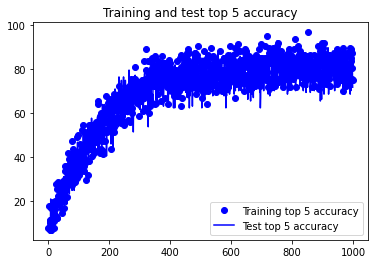

In [22]:
plt.plot(metrics['epoch'], metrics['topk'], 'bo', label='Training top 5 accuracy')
plt.plot(metrics['epoch'], metrics['test_topk'], 'b', label='Test top 5 accuracy')
plt.title('Training and test top 5 accuracy')
plt.legend()

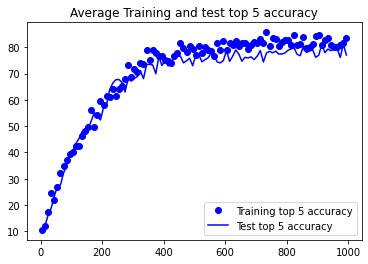

In [23]:
plt.plot(metrics_mean['epoch'], metrics_mean['topk'], 'bo', label='Training top 5 accuracy')
plt.plot(metrics_mean['epoch'], metrics_mean['test_topk'], 'b', label='Test top 5 accuracy')
plt.title('Average Training and test top 5 accuracy')
plt.legend()

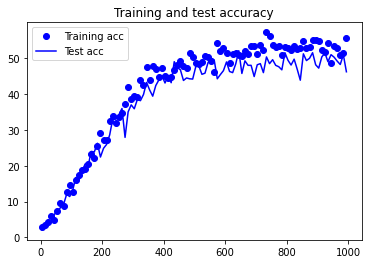

In [24]:
plt.plot(metrics_mean['epoch'], metrics_mean['acc'], 'bo', label='Training acc')
plt.plot(metrics_mean['epoch'], metrics_mean['test_acc'], 'b', label='Test acc')
plt.title('Training and test accuracy')
plt.legend()

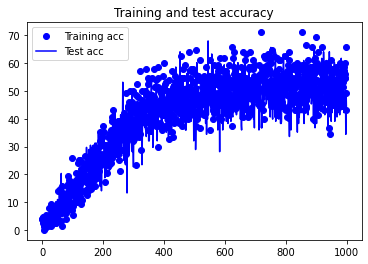

In [25]:
plt.plot(metrics['epoch'], metrics['acc'], 'bo', label='Training acc')
plt.plot(metrics['epoch'], metrics['test_acc'], 'b', label='Test acc')
plt.title('Training and test accuracy')
plt.legend()

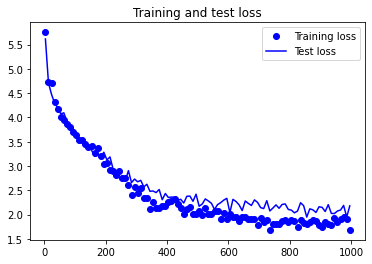

In [26]:
plt.plot(metrics_mean['epoch'], metrics_mean['loss'], 'bo', label='Training loss')
plt.plot(metrics_mean['epoch'], metrics_mean['test_loss'], 'b', label='Test loss')
plt.title('Training and test loss')
plt.legend()

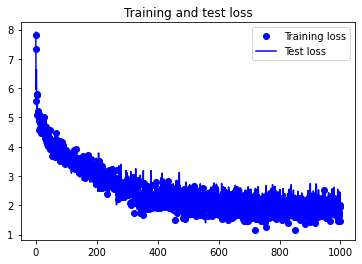

In [27]:
plt.plot(metrics['epoch'], metrics['loss'], 'bo', label='Training loss')
plt.plot(metrics['epoch'], metrics['test_loss'], 'b', label='Test loss')
plt.title('Training and test loss')
plt.legend()